You want to go as fast as possible, but not so fast as
to run off the track. In our simplified racetrack, the car is at one of a discrete set of
grid positions, the cells in the diagram. The velocity is also discrete, a number of grid
cells moved horizontally and vertically per time step. The actions are increments to the
velocity components. Each may be changed by +1, -1 or 0 for a total of 3x3 = 9 possible values. 

Both velocity components are restricted to be nonnegative and less
than 5, and they cannot both be zero except at the starting line. Each episode begins
in one of the randomly selected start states with both velocity components zero and
ends when the car crosses the finish line. The rewards are 

-1 for each step until the car
crosses the finish line. If the car hits the track boundary, it is moved back to a random
position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car’s location at each time step, check to see if
the projected path of the car intersects the track boundary. If it intersects the finish line,
the episode ends; if it intersects anywhere else, the car is considered to have hit the track
boundary and is sent back to the starting line. To make the task more challenging, with
probability 0.1 at each time step the velocity increments are both zero, independently of
the intended increments. Apply a Monte Carlo control method to this task to compute
the optimal policy from each starting state.

In [844]:
import numpy as np 
import random 
import matplotlib.pyplot as plt 
from tqdm import tqdm 

### Implementing Race Track

In [845]:
MAX_VELOCITY = 5

In [846]:
class RaceTrack:
    def __init__(self, course, racer):

        # Initialie the parameters of the model 
        self.course = course
        self._start_positions = []
        self._position = None 
        self._racer = racer 

        # Initializing functions 
        self.__load_course() 
        self.__get_start_positions()
        self.__set_start_position() 
        return  

    '''
    INVISIBLE METHODS, NOT AVAILABLE TO USERS USING THE CLASS  
    '''
    def __reset_track(self):
        self._position = None 
        # self._racer.resetCar()
        self.__set_start_position() 
        return 

    def __load_course(self):
        # Loads the course
        # Codes: 
        # 0 -> start
        # 1 -> track 
        # 2 -> end
        # -1-> wall 

        m,n = len(self.course), len(self.course[0])
        
        dc = {
            'W' : -1, 
            'o' : 1, 
            '-' : 2, 
            '+' : 0,
        }

        track = np.zeros((m,n))
        for i in range(m):
            for j in range(n):
                ele = self.course[i][j]
                track[i][j] = dc[ele]     
        self.course = track
        
        # Start from the left side of the race track 
        self.course = np.fliplr(self.course)
        return 
    
    def __get_start_positions(self):
        m,n = len(self.course),len(self.course[0])
        self._start_positions = []
        for i in range(m):
            for j in range(n):
                if self.course[i][j] == 0:
                    self._start_positions.append((i, j)) 
        return 
    
    def __set_start_position(self):
        p_index = np.random.randint(low = 0, high = len(self._start_positions) - 1,size = (1,))
        p_index = p_index[0]
        self._position = self._start_positions[p_index]  
        return

    def __update_position(self):
        # Check for walls or terminations in the velocity time 
        for t in range(MAX_VELOCITY + 1):
            tstep = t/MAX_VELOCITY

            updated_pos = self._position + np.round(self._racer.getVelocity() * tstep).astype(np.int16)

            if self.course[updated_pos[0],updated_pos[1]] == -1:
                self.__set_start_position()
                self._racer.resetCar() 
                return 
            
            if self.course[updated_pos[0],updated_pos[1]] == 2:
                self._position = updated_pos
                self._racer.resetCar() 
                return 
        
        self._position = updated_pos 
        return 

    def __int_to_tuple(self, action_id):
        if action_id < 0 or action_id > 8:
            return (0,0)
        x = action_id//3 - 1
        y = action_id%3 - 1
        return (x,y) 
    
    def __tuple_to_int(self, action):
        '''
        Action -> integer 0 to 8 => -4 to 4 
        '''
        val = action[0]*3 + action[1]
        return val + 4 
        
    '''
    VISIBLE METHODS AVAILABLE TO THE USER
    '''
    def getCurrentPosition(self):
        return self._position
    
    def getRacerVelocity(self):
        return self._racer.getVelocity() 
    
    def checkEnd(self):
        if self.course[self._position[0],self._position[1]] == 2:
            return True 
        return False 
    
    def getDimensions(self):
        return len(self.course), len(self.course[0])
    
    # reward function 
    def takeAction(self, action):
        # Check if our car is terminated at finish line or not 
        if self.checkEnd() == True: 
            return 0 
        # Now update the car's velocity 
        action_tuple = self.__int_to_tuple(action) 
        self._racer.updateVelocity(action_tuple) 

        # Use this to update the car's position 
        self.__update_position() 
        return -1
    
    def clearTrack(self):
        self.__reset_track() 
        return 
            

In [847]:
class RaceCar: 
    def __init__(self, racer_name, neglection_prob = 0):
        self.name = racer_name 
        self._velocity = np.array([0,0]) 
        self._prob = neglection_prob
        self._gamma = 0.9
        self._eps   = 0.1 

        self._pi = []
    
    def updateVelocity(self, update):
        '''
        UPDATE : A 2 tuple containing the intended speed change depending on 
        the action chosen by the Racer 
        '''
        decide = np.random.rand()

        if decide <= self._prob:
            return 
        self._velocity = self._velocity + np.array(update) 
        # Clipping the velocity between 0 and VELOCITY_MAX
        self._velocity = np.maximum(self._velocity, 0)
        self._velocity = np.minimum(self._velocity, MAX_VELOCITY)
        return  
    
    def resetCar(self):
        self.velocity = np.array([0,0]) 
        return 
    
    def getVelocity(self):
        return self._velocity
    
    def __selectAction(self,position, velocity, rd = True):
        if len(self._pi) == 0: 
            n = np.random.randint(low = 0, high = 8, size=(1,))
            return n[0]

        decide = np.random.uniform(low = 0, high = 1)

        if decide <= self._eps and rd: 
            n = np.random.randint(low = 0, high = 8, size=(1,))
            return n[0]
            
        return self._pi[position[0],position[1],int(velocity[0]),int(velocity[1])] 
    
    def completeRace(self, track : RaceTrack, explore_map = None):
        # Completes a race, returns the episode of the race
        episode = []
        track.clearTrack()
        # print(track.getCurrentPosition()) 
        self._velocity = np.array([0,0])
        
        while track.checkEnd() == False: 
            position = track.getCurrentPosition()
            velocity = track.getRacerVelocity()

            action   = self.__selectAction(position, velocity) 
            reward   = track.takeAction(action = action) 

            episode.append(((position, velocity), action, reward)) 
        
        # print(len(episode))
        return episode
    
    def trainRacer(self, track : RaceTrack):
        # print(track.course.shape)
        m,n = track.getDimensions() 

        self._Q  = np.zeros((m, n, MAX_VELOCITY + 1, MAX_VELOCITY + 1, 9)) - 40 
        self._C  = np.zeros((m, n, MAX_VELOCITY + 1, MAX_VELOCITY + 1, 9)) 
        self._pi = np.zeros((m ,n, MAX_VELOCITY + 1, MAX_VELOCITY + 1)) + 4

        for _ in tqdm(range(20000)):
            episode = self.completeRace(track = track)  
            G = 0
            W = 1

            while len(episode) > 0:
                state, action, reward = episode.pop()
                position = state[0]
                velocity = state[1] 

                coord = np.array([position[0],position[1],int(velocity[0]), int(velocity[1])]) 
                cord = np.append(coord,action).astype(int)

                cord = tuple(cord) 
                coord = tuple(coord) 

                G               = self._gamma * G + reward 
                
                self._C[cord]  = self._C[cord] + W 
                
                self._Q[cord]  = self._Q[cord] + (W/self._C[cord]) * (G - self._Q[cord]) 

                # Choose optimal action
                agmax= np.argmax(self._Q[coord])
                
            
                if self._pi[coord] != action: 
                    self._pi[coord] = agmax 
                    break 
                
                self._pi[coord] = agmax 
                W = W * (1/(1 - 8/9 * self._eps)) 
            pass 
        return 
    
    def testRacer(self, track):
        m,n = track.getDimensions()
        pos_map = np.zeros((m,n))

        track.clearTrack()
        self._velocity = np.array([0,0]) 
        while track.checkEnd() == False: 
            position = track.getCurrentPosition()
            velocity = track.getRacerVelocity()

            pos_map[position[0],position[1]] += 1

            act = self.__selectAction(position, velocity, rd = False) 

            track.takeAction(action = act)
        
        print('Results of Training the driver:', end = '\n\n\n')
        pos_map +=  track.course
        plt.imshow(np.flip(pos_map, axis = 1), cmap='hot', interpolation='nearest')
        plt.show()
    
    
    

In [848]:
race_course = ['WWWWWWWWWWWWWWWWWW',
              'WWWWooooooooooooo+',
              'WWWoooooooooooooo+',
              'WWWoooooooooooooo+',
              'WWooooooooooooooo+',
              'Woooooooooooooooo+',
              'Woooooooooooooooo+',
              'WooooooooooWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WoooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWooooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWoooooooWWWWWWWW',
              'WWWWooooooWWWWWWWW',
              'WWWWooooooWWWWWWWW',
              'WWWW------WWWWWWWW']

In [849]:
racer = RaceCar(racer_name = "Chintu", neglection_prob = 0)

In [850]:
track = RaceTrack(course = race_course, racer = racer)


In [851]:
racer.trainRacer(track = track)

100%|██████████| 20000/20000 [00:31<00:00, 638.45it/s]


Results of Training the driver:




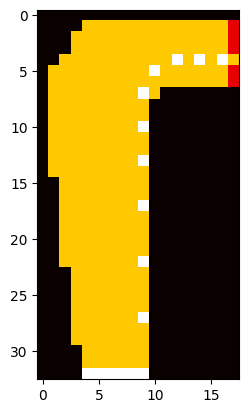

In [852]:
racer.testRacer(track = track) 